In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE


In [4]:
import os

In [5]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

root_data_dir = os.path.join(root_dir, "datasets", "BioRelEx")
print(root_data_dir)

dataset = "train"
csv_file_path = "train.csv"

offline_model_file = os.path.join(root_dir, "BiLSTM-BioRelEx-model")
training_history_csv = "training_history.csv"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/datasets/BioRelEx


##Util

In [6]:
def load_model():
    json_file = open(offline_model_file+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    new_model = model_from_json(loaded_model_json)
    # load weights into new model
    new_model.load_weights(offline_model_file+".h5")
    print("Loaded model from disk")
    return new_model

In [7]:
def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    
    with open(offline_model_file+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(offline_model_file+".h5")
    print("Saved model to disk")

In [8]:
def saveDataFrameToCSV(pd1, csv_path, append):  
  dataset_path = os.path.join(root_dir, csv_path)  
  
  if append:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=False)    
  else:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=True)

##Dataset Preprocessing


In [9]:
import os
import pandas as pd
import numpy as np

In [10]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col, names=['Label', 'Sentence'])
  data = data.fillna(method="ffill")
  return data

In [11]:
data_train = loadData(csv_file_path='train.csv', header=None, index_col=None)

In [12]:
data_train.head(10)

,Label,Sentence
0,1,"In the absence of @PROTEIN-FAMILY$ signals, ..."
1,1,These results provide evidence that complex 2 ...
2,1,"Full-length @PROTEIN$, which binds to both Cdk..."
3,0,Binding of HsOrc1 and @PROTEIN$ to @EXPERIMENT...
4,1,@PROTEIN-FAMILY$ signaling is determined by ex...
5,1,To further analyze the binding of c-Maf an...
6,1,( C) This @PROTEIN-COMPLEX$ binds the@DNA$ o...
7,1,The fact that @PROTEIN-FAMILY$ binding of dP...
8,1,This most likely occurs through the interactio...
9,1,This observation demonstrates that @PROTEIN$ ...


In [13]:
data_test = loadData(csv_file_path='test.csv', header=None, index_col=None)

In [14]:
data_test.head(10)

,Label,Sentence
0,1,The other peptide motifs that inhibit angiogen...
1,1,"In addition, these studies suggested that Arg1..."
2,1,( B) Deletion of the @PROTEIN$-binding region...
3,1,After incubating @PROTEIN$ @PROTEIN$ PKAc co...
4,1,Phosphorylation of @PROTEIN$ Y1176 inhibits L1...
5,1,EMSA competition experiments support the hypot...
6,1,@PROTEIN$ binds t@PROTEIN-FAMILY$ins via its t...
7,1,Both @PROTEIN-FAMILY$ and Hsp88@PROTEIN-FAM...
8,1,"Taken together, these results strongly implic..."
9,1,"Newer probes, designated Raichu-@PROTEIN-FAMI..."


In [15]:
data_dev = loadData(csv_file_path='dev.csv', header=None, index_col=None)

In [16]:
data_dev.head(10)

,Label,Sentence
0,1,"Thus, it appears that the holoenzyme can parti..."
1,1,We therefore altered the @PROTEIN$-interactio...
2,1,H2A-H2B stabilizes binding of @PROTEIN$@PROTEI...
3,1,"@PROTEIN-FAMILY$ can bind collagen type IV, f..."
4,1,Extracts were incubated with 20 mug of Gst-Ra...
5,1,We observed changes in the @DNA$ binding of ...
6,1,According to crystallographic studies of a @...
7,1,Growth arrest by TGF-beta is dependent on @...
8,1,Whereas FK506 stimulates the binding of @PROTE...
9,1,The adenylated Alu RNA as well as adenylated ...


In [17]:
print(len(data_train), len(data_test), len(data_dev))

1886 236 236


###Sentences 

In [18]:
train_texts = data_train[data_train.columns[1]].to_list()
train_labels = data_train[data_train.columns[0]].to_list()

In [19]:
test_texts = data_test[data_test.columns[1]].to_list()
test_labels = data_test[data_test.columns[0]].to_list()

In [20]:
dev_texts = data_dev[data_dev.columns[1]].to_list()
dev_labels = data_dev[data_dev.columns[0]].to_list()

####Exploration

In [21]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

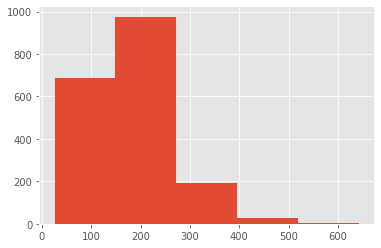

In [22]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [23]:
max([len(s) for s in train_texts])

642

In [24]:
max_len = 128 #selected value outisde the histogram

In [25]:
vocab_txt = []
vocab_txt.extend(train_texts)
print(len(vocab_txt))
vocab_txt.extend(test_texts)
print(len(vocab_txt))
vocab_txt.extend(dev_texts)
print(len(vocab_txt))

1886
2122
2358


In [26]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(vocab_txt)
print("The document count", tokenizer.document_count)
print("The count of words", tokenizer.word_counts)
print("The word index", tokenizer.word_index)

The document count 2358
The count of words OrderedDict([('in', 1348), ('the', 3666), ('absence', 41), ('of', 2830), ('protein', 4043), ('family', 718), ('signals', 10), ('lef1', 3), ('binds', 601), ('to', 2582), ('transcriptional', 49), ('co', 21), ('repressors', 6), ('tle', 2), ('ctbp', 18), ('and', 2340), ('inhibit', 31), ('gene', 35), ('expression', 40), ('22', 27), ('these', 219), ('results', 131), ('provide', 10), ('evidence', 33), ('that', 1109), ('complex', 430), ('2', 230), ('is', 612), ('due', 11), ('binding', 1529), ('t', 94), ('dna', 444), ('cc', 3), ('box', 41), ('however', 86), ('1', 327), ('appears', 21), ('be', 188), ('a', 957), ('distinct', 29), ('factor', 52), ('s', 68), ('perhaps', 12), ('krã¼ppel', 1), ('like', 47), ('specifically', 40), ('induced', 40), ('during', 31), ('me2so', 1), ('neuronal', 5), ('differentiation', 1), ('n1e', 1), ('115', 1), ('cells', 149), ('full', 31), ('length', 28), ('which', 237), ('both', 202), ('cdk', 4), ('cyclin', 55), ('effectively', 

In [28]:
n_words = len(tokenizer.word_index.keys())

In [29]:
n_words

5745

In [30]:
len(train_texts)

1886

###X & Y Prep

In [31]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def getXYFromSentences(txts, lbls):
  sequences = tokenizer.texts_to_sequences(txts)
  X = pad_sequences(maxlen=max_len, sequences=sequences, padding="post", truncating="post")
  # X = tokenizer.sequences_to_matrix(X)
  y = np.array(lbls)
  # y = np.array([to_categorical(i, num_classes=2) for i in y])
  print(X.shape)
  print(X[0:3])
  print(y.shape)
  print(y[0:3])
  return X, y

In [32]:
X_train, y_train = getXYFromSentences(train_texts, train_labels)

(1886, 128)
[[   7    2  199    3    1   10  834 2158   12    4  164  402 1254 2690
   469    5    1   10    4  276  242  203  318    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  34   58  835  256    8   19   31   11  747    4    6    3    1   81
    16 2159  200   90   19   25  403    4   41  747    4    9  298  155
   111  682    9 3848  176    1    8   11  204  205  277 3849  205 1468
  3850    3 3851 3852   50    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [33]:
X_dev, y_dev = getXYFromSentences(dev_texts, dev_labels)

(236, 128)
[[ 140   43  403    8    2 3777   53 2079  998    6    3    1    5    1
    19    4    9 5552    7    2  199    3  113    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  27  209 1728    2    1   52   21   46    2   35 5553    1    3 1712
    40 3829    4 3830    9  565    8 1462 1768    6    4 2602   36 3831
    15   14  107    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

In [34]:
X_test, y_test = getXYFromSentences(test_texts, test_labels)

(236, 128)
[[   2   92  137  273    8  276 5376  180  915    2    6    3    1    1
  5377   18  449  105 5378    3 3598 5379   26  175   72 1179  397  181
    24 2387    3 5380 5381  158 5382   15   14  101 5383 5384   15   14
   107    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   7  192   34  120  436    8 1819  577   24    9   79  788 1325  115
  1151 1031 1820   45    1    4   17    4    1   24  135   24  226   97
   709   12    4  141  316    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

##Setup the LSTM

In [35]:
from keras import callbacks
from keras.models import Model, Input, model_from_json
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.optimizers import RMSprop

In [36]:
def create_model():
  input = Input(shape=(max_len,))
  #in the line below --> laurance set the input_length = max_len-1 (NLP in TF Week4)
  model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
  model = Dropout(rate=0.1)(model)
  model = Bidirectional(LSTM(units=100, return_sequences=False, recurrent_dropout=0.1))(model)
  model = Dropout(rate=0.25)(model)
  model = Dense(512, activation='relu')(model)  
  model = Dropout(rate=0.25)(model)
  out = Dense(1,  activation='sigmoid')(model)  # segmoid output layer (binary classification)
  
  return Model(input, out)

In [37]:
model = create_model()
#model = load_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 50)           287250    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               120800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               102912    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0   

In [39]:
from tensorflow.keras.losses import BinaryCrossentropy

In [40]:
model.compile(optimizer=RMSprop(),loss=BinaryCrossentropy(reduction='sum_over_batch_size'), metrics=["accuracy"])
# model.compile(optimizer=RMSprop(),loss=BinaryCrossentropy(reduction='none'), metrics=["accuracy"])
# model.compile(optimizer=RMSprop(),loss="mse", metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [41]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.989):
      print("\nReached 98.9% accuracy so cancelling training!")
      self.model.stop_training = True
 

In [42]:
history = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), shuffle=True, batch_size=32, epochs=10, verbose=1, callbacks=[myCallback()])


Train on 1886 samples, validate on 236 samples
Epoch 1/10
1886/1886 [==============================] - 29s 15ms/step - loss: 0.2508 - accuracy: 0.9305 - val_loss: 0.1817 - val_accuracy: 0.9661
Epoch 2/10
1886/1886 [==============================] - 15s 8ms/step - loss: 0.1812 - accuracy: 0.9449 - val_loss: 0.1654 - val_accuracy: 0.9576
Epoch 3/10
1886/1886 [==============================] - 15s 8ms/step - loss: 0.1334 - accuracy: 0.9517 - val_loss: 0.1568 - val_accuracy: 0.9576
Epoch 4/10
1886/1886 [==============================] - 15s 8ms/step - loss: 0.1101 - accuracy: 0.9581 - val_loss: 0.1911 - val_accuracy: 0.9492
Epoch 5/10
1886/1886 [==============================] - 15s 8ms/step - loss: 0.0940 - accuracy: 0.9639 - val_loss: 0.1835 - val_accuracy: 0.9407
Epoch 6/10
1886/1886 [==============================] - 17s 9ms/step - loss: 0.0832 - accuracy: 0.9687 - val_loss: 0.2197 - val_accuracy: 0.9195
Epoch 7/10
1886/1886 [==============================] - 15s 8ms/step - loss: 0.07

In [43]:
save_model(model)

Saved model to disk


In [44]:
hist = pd.DataFrame(history.history)

In [45]:
saveDataFrameToCSV(hist, training_history_csv, append=True)
 

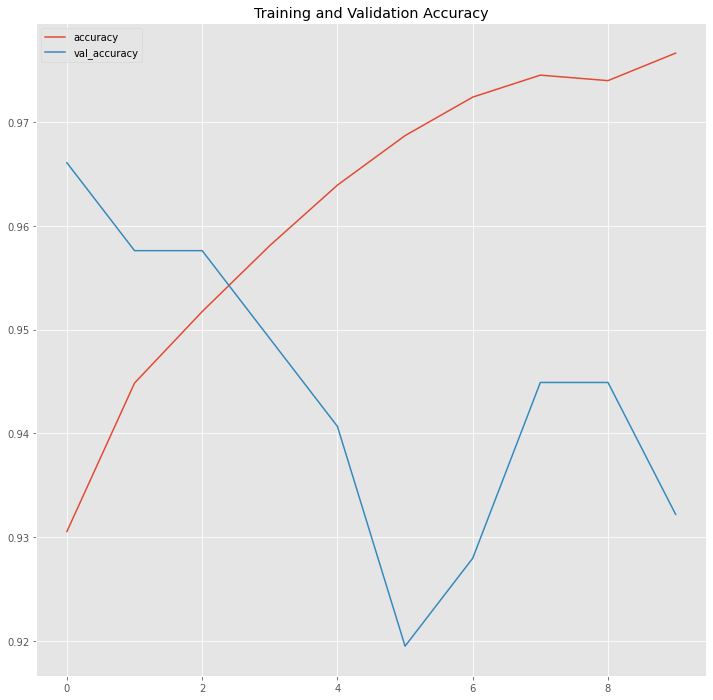

In [46]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

##Evaluation

In [47]:
model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)

236/236 [==============================] - 1s 4ms/step


[0.19645498936474956, 0.9491525292396545]

In [48]:
test_pred = model.predict(X_test, verbose=1)

236/236 [==============================] - 1s 5ms/step


In [49]:
pred_labels = [ 1 if t >= 0.5 else 0 for t in test_pred]

In [50]:
test_pred[0:10]

array([[0.9999001 ],
       [0.9999964 ],
       [0.99713904],
       [0.81548387],
       [0.99672264],
       [0.99897265],
       [0.9999995 ],
       [0.9107113 ],
       [0.99998784],
       [0.99996316]], dtype=float32)

In [51]:
pred_labels[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [52]:
test_labels[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

###Tailored Evaluation


In [53]:
from classification_metrics import classification_report, replaceMultiple

In [54]:
print(classification_report(test_labels, pred_labels))

                        precision 	 recall 	 f1-score 	 support

                   0	 0.43		 0.60		 0.50		 10	
                   1	 0.98		 0.96		 0.97		 226	


macro avg           	 0.71		 0.78		 0.74		 236	
micro avg           	 0.95		 0.95		 0.95		 236	

